## Case Study Submission by Saptarshi Ghosh and Nitin Balaji Srinivasan, Cohort 58 - AI and ML

## Gesture Recognition

#### Problem Statement & Objective


In this group project, we will build a 3D Conv model that will be able to predict the 5 gestures correctly.

Each gesture corresponds to a specific command:

 - Thumbs up:  Increase the volume
 - Thumbs down: Decrease the volume
 - Left swipe: 'Jump' backwards 10 seconds
 - Right swipe: 'Jump' forward 10 seconds  
 - Stop: Pause the movie

    
#### Objectives
 - Generator:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.
 - Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less).
 - Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 



### Approach - Steps



- Check the GPU configuration
- Importing Libraries and setting folder paths
- Generator (cropping, resizing, normalisation)
- Model development (Parameters, Prediction Time and Accuracy) - Do multiple experiments with all these models
    - CNN Conv2D + RNN(GRU)
    - CNN Conv2D + RNN (LSTM 2D)
    - Conv3D
- Evaluation and choosing final model



In [2]:
## Checking the GPU configuration

!nvidia-smi
#!gpustat

Wed May 29 12:06:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                Off | 00000000:3F:00.0 Off |                  Off |
| 33%   29C    P8              12W / 230W |      6MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Importing the libraries

In [3]:
import tensorflow as tf
#tf. __version__
import numpy as np
import os
from skimage import io,transform
#from scipy.misc import imread, imresize
import datetime
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import random as rn
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers


We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

#### Here we set the folder names and paths for training and validation. 

In [6]:
#Initialise the training and validation paths and variables

#train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())

#train_path = 'Project_data/train'
#val_path = 'Project_data/val'

train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


#### Here we initialise the `batch_size` and other image parameters. We have experimented with the batch size and arrived at batch size of 33, which has been initialised here

In [7]:
#Initialise the image variables
im_size_h=120
im_size_w=120
batch_size = 33
img_idx_shp = np.round(np.linspace(3,29,20)).astype(int)
print('Number of frames to sample', len(img_idx_shp))

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print('Steps per epoch', steps_per_epoch)
print('Validation_steps', validation_steps)

Number of frames to sample 20
Steps per epoch 21
Validation_steps 4


#### Here we initialise the model variables such as number of epochs, current date time and file path to save the model checkpoints. We also set the monitoring criteria as validation accuracy (we do not set it as val_loss because we want to ensure every improved version of the model to be saved). We also set the ReduceLRonPlateau and Early stopping criteria.  

In [8]:
#Initialise the model variables
num_epochs = 20
curr_dt_time = datetime.datetime.now()
print ('# epochs =', num_epochs)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

earlystop = EarlyStopping( monitor="val_categorical_accuracy", min_delta=0,patience=7,verbose=1)
#Stop training when plateau is reached.
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5,  verbose=1)

callbacks_list = [checkpoint, reduce_lr, earlystop]

# epochs = 20


#### As we will be initialising the image parameters and model parameters for every model instance, it would be beneficial to modularise the following
 - Initialise image parameters
 - Initialise model parameters
 - Model visualisation

In [9]:
# Initialising image parameters 
def initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=20):
    im_size_h=img_height
    im_size_w=img_width
    batch_size = b_size
    img_idx_shp = np.round(np.linspace(3,29,images_to_sample)).astype(int)
    #np.arange(5,28,2)
    print('Number of frames to sample', len(img_idx_shp))
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    
    print('Steps per epoch', steps_per_epoch)
    print('Validation_steps', validation_steps)
    return img_height,img_width,batch_size,img_idx_shp, steps_per_epoch,validation_steps

In [10]:
# Initialising model parameters 
def initialise_model_parms(ep=20):
    num_epochs = ep
    curr_dt_time = datetime.datetime.now()
    print ('# epochs =', num_epochs)
    
    
    
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    if not os.path.exists(model_name):
        os.mkdir(model_name)
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    earlystop = EarlyStopping( monitor="val_categorical_accuracy", min_delta=0,patience=7,verbose=1)
    #Stop training when plateau is reached.
    reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5,  verbose=1)

    callbacks_list = [checkpoint, reduce_lr, earlystop]
    return num_epochs,callbacks_list

In [11]:
def visualise_model_accuracy(history):
    # Visualizing the Model results:
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    print('Stopped epoch', callbacks_list[2].stopped_epoch)
    if(callbacks_list[2].stopped_epoch==0):
        epochs_range = range(num_epochs)
    else :
        epochs_range = range(callbacks_list[2].stopped_epoch+1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Generator
This is one of the most important part of the code. The generator fields every model instance with batch of images at a time. 

In this generator function, we have performed the following
 - Read a set of images from the source folder, depending on the batch size and the number of images to sample in each video sequence

 - Preprocess the images to do the following;

    - With data augmentation mode turned on (for training only);
        - Double the folder size to allow for some original images to pass through without any augmentation 
        - Randomly perform one of the following types of augmentation (Adjusting brightness/contrast, affine transformation, converting to grayscale, allow some images to pass through without augmentation)
        - Cropping the images to focus on the key gestures to avoid noise

    - For all images (with or without data augmentation):
        - Resizing to the preferred height and width and;
        - Normalisation using min/max method

 - Depending on the batch size, read the remaining set of images and apply the same preprocessing depending on with or without augmentation


In [12]:
def generator(source_path, folder_list, batch_size, img_idx_shp, augment = False, chkind = False):
    print( 'Source path = ', source_path, '; batch size =', batch_size, ';number of images =', len(img_idx_shp), ';Augmentation =', augment)
    img_idx = img_idx_shp
    np.random.seed(30)
    rn.seed(30)
    tf.random.set_seed(30)
    while True:
        if augment:
            t = np.concatenate((np.random.permutation(folder_list),np.random.permutation(folder_list)))
        else:
            t=np.random.permutation(folder_list)
        ##num_batches = len(folder_list)//batch_size
        
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx_shp),im_size_h,im_size_w,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            
            
            
            for folder in range(batch_size): # iterate over the batch_size
                
                if chkind:
                    plt.figure(figsize=(20,5))
                
                #handling remaining sequences
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                
                #imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # plotting original images for checking 
                    if chkind:
                        plt.subplot(2, len(img_idx_shp), idx+1)
                        plt.imshow(image.astype('uint8'))
                    

                    
                    ## Data Augmentation:
                    
                    if (augment):
                        aug_mode = rn.randint(0, 16) 
                        #randomly selecting the type of augmentation # Modes 11-16 allow for images to pass through without any transformation
                        #aug_mode = 7
                        if aug_mode <= 3: # Adjust brightness and contrast and crop
                            # Adjusts the brightness by adding 10 to each pixel value 
                            brightness = 3 
                            # Adjusts the contrast by scaling the pixel values by 2.3 
                            contrast = 1  
                            image = cv2.addWeighted(image, contrast, np.zeros(image.shape, image.dtype), 0, brightness)
                            ##convert the image to gray to work out the boundaries for cropping
                            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                            x0, y0 = np.argwhere(gray > 0).min(axis=0)
                            x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                            image=image[x0:x1,y0:y1,:]
                        
                        elif aug_mode <= 8: #Apply affine transformation and cropping the image
                            moved_im = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                            ##convert the image to gray to work out the boundaries for cropping
                            gray = cv2.cvtColor(moved_im,cv2.COLOR_BGR2GRAY)
                            x0, y0 = np.argwhere(gray > 0).min(axis=0)
                            x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                            image=moved_im[x0:x1,y0:y1,:]
                        
                        elif aug_mode <= 10: # Convert to grayscale and crop
                            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                            image = cv2.merge([gray,gray,gray])
                            ##convert the image to gray to work out the boundaries for cropping
                            x0, y0 = np.argwhere(gray > 0).min(axis=0)
                            x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                            image=image[x0:x1,y0:y1,:]
                      
                        elif aug_mode > 10: #pass original image with cropping before resizing
                            ##convert the image to gray to work out the boundaries for cropping
                            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                            x0, y0 = np.argwhere(gray > 0).min(axis=0)
                            x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                            image=image[x0:x1,y0:y1,:]
                   
                        
                   
                    #Resizing images
                    resizedImage = transform.resize(image, (im_size_h, im_size_w) , 3)
                    
                    #if (augment):
                     #   if aug_mode == 11:
                      #      resizedImage = np.array(Image.fromarray(resizedImage, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                
             
                    # plotting resized images for checking 
                    if chkind:
                        plt.subplot(2, len(img_idx_shp), idx+len(img_idx_shp)+1)
                        plt.imshow(resizedImage.astype('uint8'))
                            
                            
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    
                    batch_data[folder,idx,:,:,0] = (resizedImage[:,:,0]-np.min(resizedImage[:,:,0]))/((np.max(resizedImage[:,:,0])-np.min(resizedImage[:,:,0])))
                    batch_data[folder,idx,:,:,1] = (resizedImage[:,:,1]-np.min(resizedImage[:,:,1]))/((np.max(resizedImage[:,:,1])-np.min(resizedImage[:,:,1])))
                    batch_data[folder,idx,:,:,2] = (resizedImage[:,:,2]-np.min(resizedImage[:,:,2]))/((np.max(resizedImage[:,:,2])-np.min(resizedImage[:,:,2])))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



In [ ]:
### Checking if the image numbers in the array are picked up correctly
# img_idx_shp

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

Source path =  /datasets/Project_data/train ; batch size = 1 ;number of images = 20 ;Augmentation = True


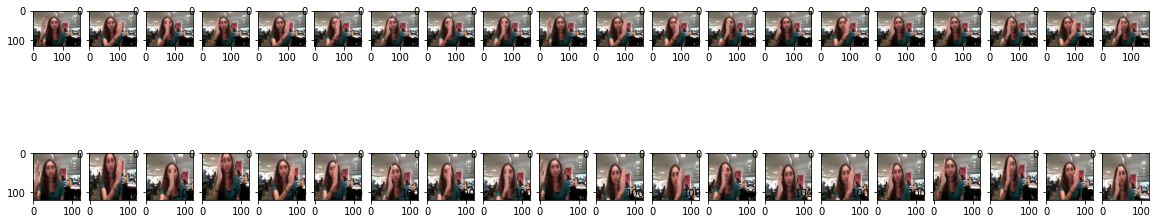

In [15]:
# testing generator for aug_mode=7
#test_gen = generator(train_path, train_doc, 1, img_idx_shp, chkind = True, augment = True)
#d = next(test_gen)[0]

### Model Runs
Here we make multiple using different functionalities that Keras provides. 

We have built 3D Convolution models (Conv3D) and the standard (CNN + RNN based) models to predict the 5 gestures.
In experimenting the models, we have tried various model definitions, hyper-parameters and combinations of filter sizes. Our aim is to design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

#### Model 1 - Two Conv3D layers and no Dropouts with Augment=True

In [73]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=15)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 15
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [74]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=input_shape,activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))







#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))


model.add(Dense(5,activation='softmax'))

In [75]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_28 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 86400)             0         
                                                                 
 dense_14 (Dense)            (None, 512)              

In [76]:
# Train model with augmentation

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp,augment = True)
val_generator = generator(val_path, val_doc, batch_size,img_idx_shp)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_28 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 86400)             0         
                                                                 
 dense_14 (Dense)            (None, 512)              

In [77]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 15 ;Augmentation = True
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 5.8515 - categorical_accuracy: 0.2251Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 15 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.25000, saving model to model_init_2024-05-2911_53_21.249747/model-00001-5.85151-0.22511-1.22562-0.25000.h5
21/21 [==============================] - 190s 9s/step - loss: 5.8515 - categorical_accuracy: 0.2251 - val_loss: 1.2256 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4458 - categorical_accuracy: 0.3232
Epoch 00002: val_categorical_accuracy improved from 0.25000 to 0.32576, saving model to model_init_2024-05-2911_53_21.249747/model-00002-1.44584-0.32323-1.03701-0.32576.h5
21/21 [==============================] - 139s 7s/step - loss: 1.4458 

Stopped epoch 19


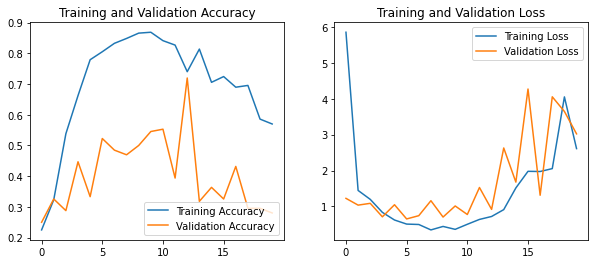

In [78]:
# Visualise model outputs
visualise_model_accuracy(history)

#### The training and validation curves suggest that the model is experiencing significant overfitting, as evidenced by the training accuracy continuing to improve while the validation accuracy fluctuates and does not improve consistently. Additionally, the validation loss is quite volatile, which further indicates instability in generalization. Here are some targeted improvements to address these issues:

 - Add Dropout Layers: Introduce dropout layers after each convolutional and dense layer to help prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

 - Increase Regularization: Apply L2 regularization (weight decay) to the Conv3D and Dense layers. This penalizes large weights and can help in generalization.

 - Add batch normalization layers after each Conv3D layer to stabilize and accelerate the training process

 - Given the large number of parameters (44 million), the model might be too complex for your dataset size.

#### Model 2: Experimenting with Dropout,L2 Regularizer and decreased dense layer neurons with Augment=True:

In [85]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=15)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 15
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [86]:
#Model definition
from tensorflow.keras.regularizers import l2

input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=input_shape, kernel_regularizer=l2(0.01), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.4))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same', kernel_regularizer=l2(0.01),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.4))








#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(5,activation='softmax'))

In [87]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 batch_normalization_10 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_33 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 batch_normalization_11 (Bat  (None, 7, 60, 60, 32)  

In [88]:
# Run the generators

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp,augment = True)
val_generator = generator(val_path, val_doc, batch_size,img_idx_shp)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 batch_normalization_10 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_33 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 batch_normalization_11 (Bat  (None, 7, 60, 60, 32)  

In [89]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 15 ;Augmentation = True
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 48.0393 - categorical_accuracy: 0.2626Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 15 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.12879, saving model to model_init_2024-05-2913_35_59.810451/model-00001-48.03934-0.26263-2.51208-0.12879.h5
21/21 [==============================] - 156s 8s/step - loss: 48.0393 - categorical_accuracy: 0.2626 - val_loss: 2.5121 - val_categorical_accuracy: 0.1288 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.9150 - categorical_accuracy: 0.2684
Epoch 00002: val_categorical_accuracy improved from 0.12879 to 0.15152, saving model to model_init_2024-05-2913_35_59.810451/model-00002-1.91502-0.26840-4.91447-0.15152.h5
21/21 [==============================] - 137s 7s/step - loss: 1.91

Stopped epoch 12


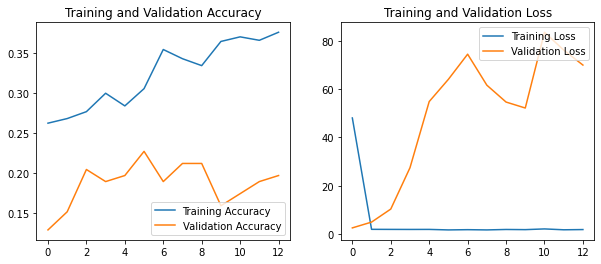

In [90]:
# Visualise model outputs
visualise_model_accuracy(history)

#### As we can see there is still overfitting and the model is performing horribly worse. Both Training and validation accuracy is not good and this is due to the fact that it isn't able to learn the features good enough. So now we are proceeding with one additinal layer and see if things change.


#### Model 3 - Three Conv3D layers with Dropout and Augment=True:

In [79]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=15)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 15
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [80]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=input_shape,activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))



#layer3:
model.add(Conv3D(64,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))




#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(5,activation='softmax'))

In [81]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_29 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_30 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 3, 30, 30, 32)   

In [82]:
# Run the generators

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp,augment = True)
val_generator = generator(val_path, val_doc, batch_size,img_idx_shp)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_29 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_30 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 3, 30, 30, 32)   

In [83]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 15 ;Augmentation = True
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.9826 - categorical_accuracy: 0.2063Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 15 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17424, saving model to model_init_2024-05-2912_39_42.212174/model-00001-2.98260-0.20635-1.21948-0.17424.h5
21/21 [==============================] - 143s 7s/step - loss: 2.9826 - categorical_accuracy: 0.2063 - val_loss: 1.2195 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5450 - categorical_accuracy: 0.2453
Epoch 00002: val_categorical_accuracy did not improve from 0.17424
21/21 [==============================] - 138s 7s/step - loss: 1.5450 - categorical_accuracy: 0.2453 - val_loss: 1.2194 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 3

Stopped epoch 23


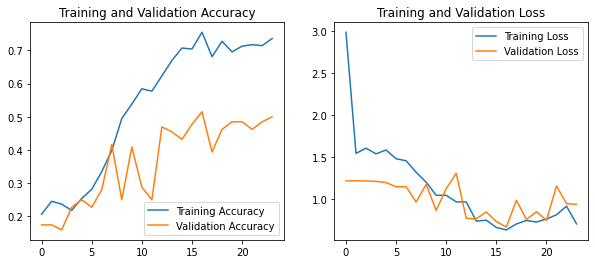

In [84]:
# Visualise model outputs
visualise_model_accuracy(history)

#### Given that the addition of dropout at a rate of 0.2 has not stabilized the validation curves, it suggests that further adjustments are necessary. Here are several strategies we can implement to improve the stability and performance of the model:

 - Increase Dropout Rate Further: Incrementally increase the dropout rate to 0.3 or 0.4. Higher dropout rates can provide stronger regularization and prevent overfitting.

 - Batch Normalization: Introduce batch normalization layers after each convolutional layer. Batch normalization helps in normalizing the activations, which can stabilize and speed up the training process.

 - Simplify the Model:
    Consider reducing the complexity of the model. This can involve:

    - Decreasing the number of filters in the Conv3D layers.
    - Reducing the number of neurons in the dense layers.
    - Removing layers that may be contributing to overfitting.


 - Increase Regularization:
    Apply stronger L2 regularization to the Conv3D and Dense layers. Regularization can help to penalize large weights, encouraging the model to generalize better.

#### Model 4 - Conv3D with 3 layers, dropout and no batch normalisation and Augment = False:

In [91]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=15)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 15
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [92]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=input_shape,activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))



#layer3:
model.add(Conv3D(64,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))




#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(5,activation='softmax'))

In [93]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_34 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_35 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_35 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 3, 30, 30, 32)   

In [94]:
# Run the generators

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp,augment = False)
val_generator = generator(val_path, val_doc, batch_size,img_idx_shp)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_34 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_35 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_35 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 3, 30, 30, 32)   

In [95]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 15 ;Augmentation = False
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.7765 - categorical_accuracy: 0.2049Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 15 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.15909, saving model to model_init_2024-05-2914_06_23.578825/model-00001-2.77647-0.20491-1.21927-0.15909.h5
21/21 [==============================] - 122s 6s/step - loss: 2.7765 - categorical_accuracy: 0.2049 - val_loss: 1.2193 - val_categorical_accuracy: 0.1591 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5385 - categorical_accuracy: 0.2482
Epoch 00002: val_categorical_accuracy improved from 0.15909 to 0.20455, saving model to model_init_2024-05-2914_06_23.578825/model-00002-1.53850-0.24820-1.21902-0.20455.h5
21/21 [==============================] - 120s 6s/step - loss: 1.5385

Stopped epoch 16


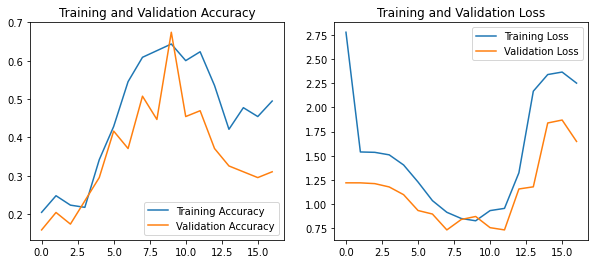

In [96]:
# Visualise model outputs
visualise_model_accuracy(history)

#### Although there still is overfitting but the gap between the training curve and accuracy curve is highly minimized and Also the training accuracy increases as compared to the baseline 2 layered models without dropouts. Proceeding with Data Augmentation further to enhance the 3 layered model performance.

#### Model 5- Conv3D with 3 layers, no Dropout and no batch normalisation and Augment = True:

In [97]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=15)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 15
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [98]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=input_shape,activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))



#layer3:
model.add(Conv3D(64,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))




#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))


model.add(Dense(5,activation='softmax'))

In [99]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_37 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_38 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_39 (Conv3D)          (None, 3, 30, 30, 64)     16448     
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 1, 15, 15, 64)  

In [100]:
# Run the generators

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp,augment = True)
val_generator = generator(val_path, val_doc, batch_size,img_idx_shp)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_37 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_38 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_39 (Conv3D)          (None, 3, 30, 30, 64)     16448     
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 1, 15, 15, 64)  

In [101]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 15 ;Augmentation = True
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.7223 - categorical_accuracy: 0.2583Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 15 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22727, saving model to model_init_2024-05-2914_40_59.052218/model-00001-1.72226-0.25830-1.18661-0.22727.h5
21/21 [==============================] - 139s 7s/step - loss: 1.7223 - categorical_accuracy: 0.2583 - val_loss: 1.1866 - val_categorical_accuracy: 0.2273 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4138 - categorical_accuracy: 0.3348
Epoch 00002: val_categorical_accuracy improved from 0.22727 to 0.41667, saving model to model_init_2024-05-2914_40_59.052218/model-00002-1.41384-0.33478-0.93615-0.41667.h5
21/21 [==============================] - 134s 7s/step - loss: 1.4138 

Stopped epoch 12


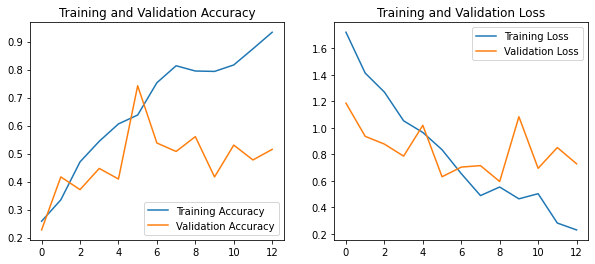

In [102]:
# Visualise model outputs
visualise_model_accuracy(history)

#### Data Augmentation seems to have definitely helped to get better results but there is still overfitting. Hence, using Dropouts finally to deal with overfitting.

#### Model 6 - Conv3D with 3 layers, dropout and no batch normalisation and Augment = True:

In [103]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=15)
num_epochs,callbacks_list=initialise_model_parms(ep=50)

Number of frames to sample 15
Steps per epoch 21
Validation_steps 4
# epochs = 50


In [104]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=input_shape,activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))



#layer3:
model.add(Conv3D(64,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.3))




#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(5,activation='softmax'))

In [105]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_41 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_41 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 3, 30, 30, 32)   

In [106]:
# Run the generators

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp,augment = True)
val_generator = generator(val_path, val_doc, batch_size,img_idx_shp)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 15, 120, 120, 16)  400       
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_41 (Conv3D)          (None, 7, 60, 60, 32)     4128      
                                                                 
 max_pooling3d_41 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 3, 30, 30, 32)   

In [107]:
num_epochs

50

In [108]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 15 ;Augmentation = True
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 2.9826 - categorical_accuracy: 0.2063Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 15 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17424, saving model to model_init_2024-05-2915_10_26.105460/model-00001-2.98260-0.20635-1.21948-0.17424.h5
21/21 [==============================] - 139s 7s/step - loss: 2.9826 - categorical_accuracy: 0.2063 - val_loss: 1.2195 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.5450 - categorical_accuracy: 0.2453
Epoch 00002: val_categorical_accuracy did not improve from 0.17424
21/21 [==============================] - 135s 7s/step - loss: 1.5450 - categorical_accuracy: 0.2453 - val_loss: 1.2194 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 3

Stopped epoch 27


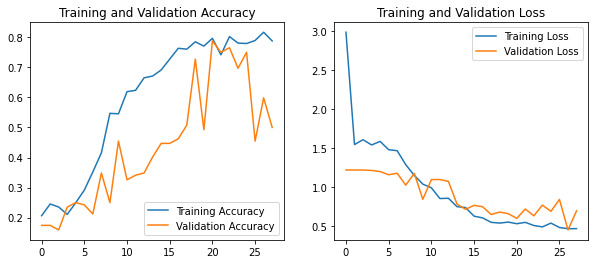

In [109]:
# Visualise model outputs
visualise_model_accuracy(history)

#### The model performance is significantly better than the rest of the Conv3D models and the validation loss curve is also very similar to the training loss curve. The same can be seen with the validation accuracy as wellwhich is by far the highest. 

Lets increase the "number of images to sample" by 1 and try CNN + RNN based models


#### Model 7 - 4 Conv2D layers + LSTM with 64 lstm cells

In [54]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=16)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [24]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, kernel_size= (3,3), activation='relu'), input_shape=input_shape)
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(32, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(64, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(128, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))


#model.add(TimeDistributed(
#    Conv2D(128, kernel_size=(3,3), activation='relu'))
#)
#model.add(BatchNormalization())
#model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64)) #lstm_cells = 64
model.add(Dropout(0.5))
    
        
#model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [25]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 16, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 16, 26, 26, 64)  

In [26]:
# Run the generators

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp, augment = False)
val_generator = generator(val_path, val_doc, batch_size, img_idx_shp)
model.summary()

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 16, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                      

In [27]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 16 ;Augmentation = False
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5522 - categorical_accuracy: 0.2092Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 16 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17424, saving model to model_init_2024-05-2818_02_48.715053/model-00001-1.55216-0.20924-1.21147-0.17424.h5
21/21 [==============================] - 130s 6s/step - loss: 1.5522 - categorical_accuracy: 0.2092 - val_loss: 1.2115 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5235 - categorical_accuracy: 0.2121
Epoch 00002: val_categorical_accuracy improved from 0.17424 to 0.19697, saving model to model_init_2024-05-2818_02_48.715053/model-00002-1.52351-0.21212-1.17424-0.19697.h5
21/21 [==============================] - 130s 6s/step - loss: 1.5235

Stopped epoch 15


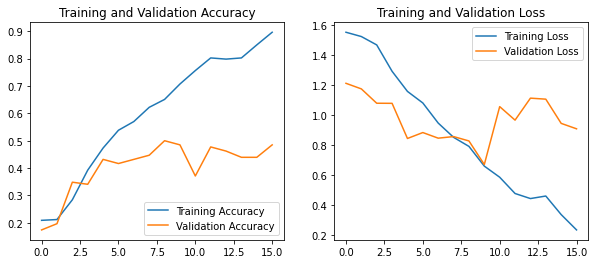

In [28]:
visualise_model_accuracy(history)

#### There is a significant overfitting issue and the validation accuracy is not high. Lets try with augmentation and also with ConvLSTM model

#### Model 8 - 3 Conv2D layers + 1 ConvLSTM2D layer

In [40]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=16)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [41]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, kernel_size= (3,3), activation='relu'), input_shape=input_shape)
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(32, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(64, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

#model.add(TimeDistributed(
#    Conv2D(128, kernel_size=(3,3), activation='relu'))
#)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

##LSTM2D

model.add(
    ConvLSTM2D(16, kernel_size = 3, return_sequences=False)
)
#model.add(BatchNormalization())
    

model.add(GlobalAveragePooling2D())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [42]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 26, 26, 64)  

In [43]:
#Run the generator without augmentation

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp, augment = False)
val_generator = generator(val_path, val_doc, batch_size, img_idx_shp)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 26, 26, 64)  

In [21]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 16 ;Augmentation = False
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5465 - categorical_accuracy: 0.1818Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 16 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17424, saving model to model_init_2024-05-2821_08_07.904569/model-00001-1.54647-0.18182-1.21739-0.17424.h5
21/21 [==============================] - 139s 7s/step - loss: 1.5465 - categorical_accuracy: 0.1818 - val_loss: 1.2174 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5388 - categorical_accuracy: 0.2150
Epoch 00002: val_categorical_accuracy improved from 0.17424 to 0.18939, saving model to model_init_2024-05-2821_08_07.904569/model-00002-1.53881-0.21501-1.21473-0.18939.h5
21/21 [==============================] - 126s 6s/step - loss: 1.5388

Stopped epoch 13


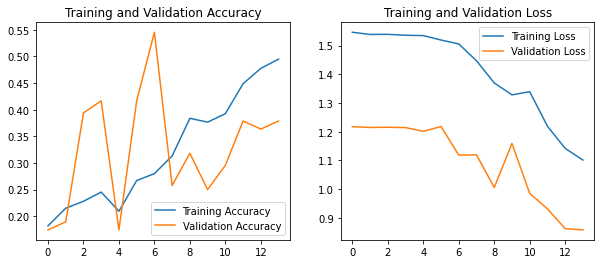

In [22]:
# Visualise model outputs
visualise_model_accuracy(history)

#### The ConvLSTM model has low number of parameters but the accuracy is really low. We need to try this with augmentation

In [44]:
#Run the generator
train_generator = generator(train_path, train_doc, batch_size, img_idx_shp, augment = True)
val_generator = generator(val_path, val_doc, batch_size, img_idx_shp)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 26, 26, 64)  

In [45]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 16 ;Augmentation = True
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6087 - categorical_accuracy: 0.2150Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 16 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17424, saving model to model_init_2024-05-2915_20_15.631792/model-00001-1.60869-0.21501-1.21425-0.17424.h5
21/21 [==============================] - 245s 12s/step - loss: 1.6087 - categorical_accuracy: 0.2150 - val_loss: 1.2143 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5450 - categorical_accuracy: 0.2092 
Epoch 00002: val_categorical_accuracy improved from 0.17424 to 0.18182, saving model to model_init_2024-05-2915_20_15.631792/model-00002-1.54503-0.20924-1.20808-0.18182.h5
21/21 [==============================] - 248s 12s/step - loss: 1.54

Stopped epoch 20


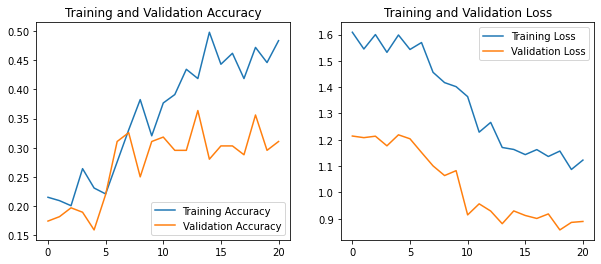

In [46]:
# Visualise model outputs
visualise_model_accuracy(history)

#### The accuracy has still not improved therefore it would be worth trying GRU if it helps improve the accuracy

#### Model 9 - 4 Conv2D layers + GRU with 64 GRU cells

In [54]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=16)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [16]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, kernel_size= (3,3), activation='relu'), input_shape=input_shape)
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(32, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(64, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(128, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))


#model.add(TimeDistributed(
#    Conv2D(128, kernel_size=(3,3), activation='relu'))
#)
#model.add(BatchNormalization())
#model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(64)) #GRU = 64
model.add(Dropout(0.5))
    
        
#model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 16, 118, 118, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 26, 26, 64)  

In [18]:
# Run the generator

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp, augment = False)
val_generator = generator(val_path, val_doc, batch_size, img_idx_shp)
model.summary()

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 16, 118, 118, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                      

In [19]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 16 ;Augmentation = False
Epoch 1/30


2024-05-28 17:04:19.774719: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5447 - categorical_accuracy: 0.1977Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 16 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17424, saving model to model_init_2024-05-2817_03_59.013574/model-00001-1.54470-0.19769-1.20840-0.17424.h5
21/21 [==============================] - 135s 6s/step - loss: 1.5447 - categorical_accuracy: 0.1977 - val_loss: 1.2084 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5278 - categorical_accuracy: 0.2049
Epoch 00002: val_categorical_accuracy improved from 0.17424 to 0.26515, saving model to model_init_2024-05-2817_03_59.013574/model-00002-1.52781-0.20491-1.19888-0.26515.h5
21/21 [==============================] - 127s 6s/step - loss: 1.5278 - categorical_accuracy: 0.2049 - val_loss: 1.1989 - val_categorical_accuracy: 0.2652 - lr: 0.0010
Epoch 3/30
21/21 [=

Stopped epoch 24


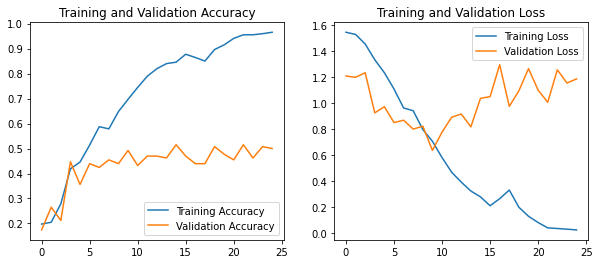

In [20]:
# Visualise model outputs
visualise_model_accuracy(history)

#### Overfitting issue, so we need to try GRU with data augmentation

#### Model 10 - Transfer learning + LSTM with 64 lstm cells

In [26]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)


In [27]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=16)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [28]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
        
        
for layer in model.layers:
    layer.trainable = False
            
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64)) #lstm_cells = 64
model.add(Dropout(0.25))
    
        
#model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [29]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 3, 3, 1024)   4096      
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)               

In [30]:
# Run the generator

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp,  augment = False)
val_generator = generator(val_path, val_doc, batch_size, img_idx_shp)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 3, 3, 1024)   4096      
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)               

In [31]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 16 ;Augmentation = False
Epoch 1/30
20/21 [===========================>..] - ETA: 5s - loss: 1.5142 - categorical_accuracy: 0.3424 
Epoch 00001: val_categorical_accuracy improved from -inf to 0.28030, saving model to model_init_2024-05-2913_37_27.124356/model-00001-1.44937-0.35065-1.05317-0.28030.h5
21/21 [==============================] - 132s 6s/step - loss: 1.4494 - categorical_accuracy: 0.3506 - val_loss: 1.0532 - val_categorical_accuracy: 0.2803 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.0188 - categorical_accuracy: 0.6407
Epoch 00002: val_categorical_accuracy improved from 0.28030 to 0.47727, saving model to model_init_2024-05-2913_37_27.124356/model-00002-1.01880-0.64069-0.73148-0.47727.h5
21/21 [==============================] - 129s 6s/step - loss: 1.0188 - categorical_accuracy: 0.6407 - val_loss: 0.7315 - val_categorical_accuracy: 0.4773 - lr: 0.0010
Epoch

Stopped epoch 21


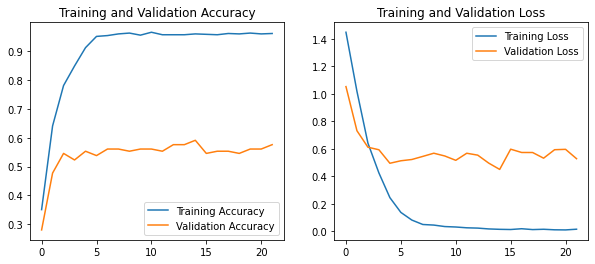

In [32]:
# Visualise model outputs
visualise_model_accuracy(history)

#### There is a huge overfitting issue. Increase drop out and run this with image augmentation to see if it helps to reduce "overfitting" improves the validation accuracy

#### Model 11 - 4 Conv2D layers + LSTM with 64 lstm cells with Augment=True

In [48]:
#Initialise image and model parameters and Train model
img_height,img_width,batch_size, img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=16)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [49]:
#Model definition
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, kernel_size= (3,3), activation='relu'), input_shape=input_shape)
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(32, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(64, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(128, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))


#model.add(TimeDistributed(
#    Conv2D(128, kernel_size=(3,3), activation='relu'))
#)
#model.add(BatchNormalization())
#model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64)) #lstm_cells = 64
model.add(Dropout(0.5))
    
        
#model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [50]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 16, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 26, 26, 64)  

In [51]:
# Run the generators
train_generator = generator(train_path, train_doc, batch_size, img_idx_shp, augment = True)
val_generator = generator(val_path, val_doc, batch_size, img_idx_shp)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 16, 118, 118, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 59, 59, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 57, 57, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 28, 28, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 26, 26, 64)  

In [52]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 16 ;Augmentation = True
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6206 - categorical_accuracy: 0.2222Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 16 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.19697, saving model to model_init_2024-05-2909_43_17.012742/model-00001-1.62063-0.22222-1.21703-0.19697.h5
21/21 [==============================] - 152s 7s/step - loss: 1.6206 - categorical_accuracy: 0.2222 - val_loss: 1.2170 - val_categorical_accuracy: 0.1970 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5428 - categorical_accuracy: 0.2121
Epoch 00002: val_categorical_accuracy did not improve from 0.19697
21/21 [==============================] - 148s 7s/step - loss: 1.5428 - categorical_accuracy: 0.2121 - val_loss: 1.1996 - val_categorical_accuracy: 0.1591 - lr: 0.0010
Epoch 3

Stopped epoch 20


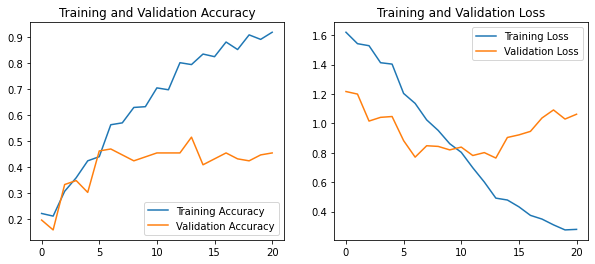

In [53]:
# Visualise model outputs
visualise_model_accuracy(history)

#### The data augmentation has only marginally improved Model 7. Lets try augmentation on the Transfer Learning model

#### Model 12 - Transfer learning + LSTM with 64 lstm cells with Augment=True

In [38]:
#Initialise image and model parameters and Train model
img_height,img_width,batch_size, img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=16)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [39]:
#Define the model
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
        
        
for layer in model.layers:
    layer.trainable = False
            
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64)) #lstm_cells = 64
model.add(Dropout(0.4))
    
        
#model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [40]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 64)                278784    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [41]:
# Run the generator for the model
train_generator = generator(train_path, train_doc, batch_size, img_idx_shp, augment = True)
val_generator = generator(val_path, val_doc, batch_size, img_idx_shp)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 64)                278784    
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                      

In [42]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 16 ;Augmentation = True
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6049 - categorical_accuracy: 0.2540 Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 16 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.31818, saving model to model_init_2024-05-2908_06_39.939525/model-00001-1.60487-0.25397-1.10417-0.31818.h5
21/21 [==============================] - 352s 17s/step - loss: 1.6049 - categorical_accuracy: 0.2540 - val_loss: 1.1042 - val_categorical_accuracy: 0.3182 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.3575 - categorical_accuracy: 0.3911
Epoch 00002: val_categorical_accuracy improved from 0.31818 to 0.40152, saving model to model_init_2024-05-2908_06_39.939525/model-00002-1.35751-0.39105-1.03741-0.40152.h5
21/21 [==============================] - 150s 7s/step - loss: 1.357

Stopped epoch 21


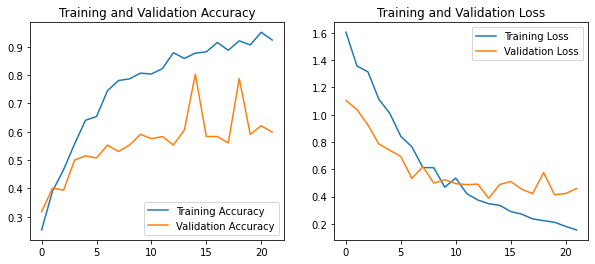

In [43]:
# Visualise model outputs
visualise_model_accuracy(history)

#### After 15 epochs, this model achieved 80% validation accuracy but then did not improve in the following 7 epochs. Given the broader trend, it may be worth trying to run the model for another 10 epochs. 

In [44]:
#Running the model for additional 10 epochs
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.1309 - categorical_accuracy: 0.9726
Epoch 00001: val_categorical_accuracy did not improve from 0.80303
21/21 [==============================] - 148s 7s/step - loss: 0.1309 - categorical_accuracy: 0.9726 - val_loss: 0.4101 - val_categorical_accuracy: 0.6212 - lr: 2.0000e-04
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.1298 - categorical_accuracy: 0.9466
Epoch 00002: val_categorical_accuracy did not improve from 0.80303
21/21 [==============================] - 145s 7s/step - loss: 0.1298 - categorical_accuracy: 0.9466 - val_loss: 0.4301 - val_categorical_accuracy: 0.6061 - lr: 2.0000e-04
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.1405 - categorical_accuracy: 0.9553
Epoch 00003: val_categorical_accuracy did not improve from 0.80303
21/21 [==============================] - 152s 8s/step - loss: 0.1405 - categorical_accuracy: 0.9553 - val_loss: 0.4768 - val_categorical_ac

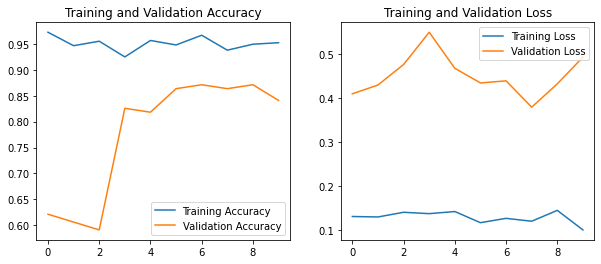

In [47]:
    # Visualizing the Model results:
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(10)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### Great result. After 28 epochs in total, this model achieves a good level of accuracy with reduced overfitting and with relatively low number of trainable parameters

#### Model 13 - 4 Conv2D layers + GRU with 64 GRU cells with augment = True

In [33]:
#Initialise image and model parameters

img_height,img_width,batch_size,img_idx_shp,steps_per_epoch,validation_steps=initialise_image_parms(img_height=120,img_width=120,b_size=33,images_to_sample=16)
num_epochs,callbacks_list=initialise_model_parms(ep=30)

Number of frames to sample 16
Steps per epoch 21
Validation_steps 4
# epochs = 30


In [34]:
#Define the model
input_shape = (len(img_idx_shp), im_size_h, im_size_w, 3)
np.random.seed(30)

model = Sequential()
model.add(TimeDistributed(
    Conv2D(16, kernel_size= (3,3), activation='relu'), input_shape=input_shape)
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(32, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(64, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(
    Conv2D(128, kernel_size=(3,3), activation='relu'))
)
#model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D((2, 2))))


#model.add(TimeDistributed(
#    Conv2D(128, kernel_size=(3,3), activation='relu'))
#)
#model.add(BatchNormalization())
#model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(64)) #GRU = 64
model.add(Dropout(0.5))
    
        
#model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [35]:
# Compile the model with optimiser
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 16, 118, 118, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 59, 59, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 57, 57, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 28, 28, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 26, 26, 64)  

In [37]:
# Run the generator

train_generator = generator(train_path, train_doc, batch_size, img_idx_shp, augment = True)
val_generator = generator(val_path, val_doc, batch_size, img_idx_shp)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 16, 118, 118, 16)  448      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 59, 59, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 57, 57, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 28, 28, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 26, 26, 64)  

In [38]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 33 ;number of images = 16 ;Augmentation = True
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6142 - categorical_accuracy: 0.2208Source path =  /datasets/Project_data/val ; batch size = 33 ;number of images = 16 ;Augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.17424, saving model to model_init_2024-05-2914_33_48.520702/model-00001-1.61417-0.22078-1.20963-0.17424.h5
21/21 [==============================] - 151s 7s/step - loss: 1.6142 - categorical_accuracy: 0.2208 - val_loss: 1.2096 - val_categorical_accuracy: 0.1742 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5287 - categorical_accuracy: 0.2309
Epoch 00002: val_categorical_accuracy improved from 0.17424 to 0.21212, saving model to model_init_2024-05-2914_33_48.520702/model-00002-1.52874-0.23088-1.17861-0.21212.h5
21/21 [==============================] - 147s 7s/step - loss: 1.5287 

Stopped epoch 11


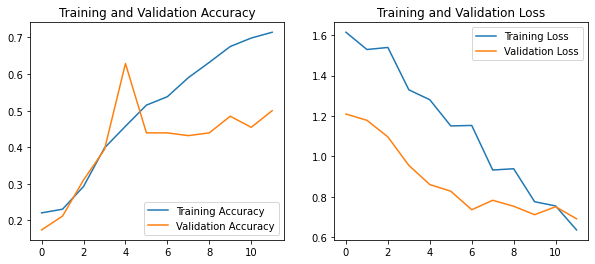

In [39]:
# Visualise model outputs
visualise_model_accuracy(history)

#### The validation accuracy has improved following data augmentation but it is not high enough, though there is no overfitting!

### Best Model:

### We will choose "Model 12 - Transfer learning + LSTM with 64 lstm cells with Augment=True" as the best model as this achieves a good level of accuracy with reduced overfitting and ### with relatively low number of trainable parameters

